# Combined Datasets

In [1]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score

# Data

Data explanation placeholder

(Talk about original two notebooks?)

In [2]:
# Reading in data
df_movies = pd.read_csv("./Resources/movies_data.csv")

### Movie Data

# Economics Data

While classifying economic states is a complex and nuanced issue, it is not unreasonable to draw more broad-strokes generalizations about a given timeframe based on more limited factors. To serve the purposes of our modelling, the following three factors were chosen to highlight the economic status at a given movie's release date;

* Consumer Confidence Indicator (CCI)
* Consumer Price Index (CPI)
* Unemployment Rate

These features are further discussed below, and stand as adequate datapoints to answer three respective questions;

* How likely are people to be spending money?
* How much do things cost when they do spend money?
* How many people have jobs to earn money to spend?

As detailed below, this information came as monthly measures over several decades. To create our `Economic Climate` indicator - a classification as to whether or not the economics of a given time were on the better side for consumers - we will need to calculate a rolling 12-month percent change in the mean of those monthly values in order to show if a given feature was on a positive or negative trend for the provided period.

---

The following datasets are courtesy of __[Kaggle](https://www.kaggle.com/)__.

### __['...CCI_OECD.csv'](https://www.kaggle.com/datasets/iqbalsyahakbar/cci-oecd)__

*renamed from `DP_LIVE_16112023095843236.csv`*

Per the Organisation for Economic Co-operation and Development (OECD);

* The CCI is an indication of developments for future households' consumption and saving based on expected financial situation, sentiment regarding the general economic situation, employment status, and capacity for savings
* An indicator above `100` indicates an optimistic outlook and a greater likliehood to spend money over cautious saving
* An indicator below `100` indicates a pessimistic outlook and both a higher likeliehood to save money and a lower tendency to consume

### __['...US_inflation_rates.csv'](https://www.kaggle.com/datasets/pavankrishnanarne/us-inflation-dataset-1947-present)__

Per the dataset description;

* The CPI is a critical economic indicator for measuring the purchasing power of money over time, measuring the average change over time in the prices paid by urban consumers for goods and services
* The CPI is the value at the end of the respective month

---

The following datasets are courtesy of the __[Economic Policy Institute’s (EPI) State of Working America Data Library](https://www.epi.org/data/)__.

### __['...Unemployment.csv'](https://www.epi.org/data/#?subject=unemp)__

Per EPI description;

* Unemployment is the share of the labor force wihout a job
* Monthly percentages calculated as a rolling 12-month average (mean)

In [3]:
# Reading in data
df_unemp = pd.read_csv("./Resources/EPI Data Library - Unemployment.csv")
df_cci = pd.read_csv("./Resources/CCI_OECD.csv")
df_inflation = pd.read_csv("./Resources/US_inflation_rates.csv")

## Defining functions

Since each dataset will need similar preprocessing, the following functions will be used to help streamline the flow and code.

### Universal functions

Applicable to all datasets

#### EDA routine

Labelling and displaying pertinant information about a given dataset for the purposes of expedited EDA

#### Copying datasets

Creating a working copy of a given dataset to preserve the original DF with unneeded features dropped

#### Renaming needed features

Renaming selected features for a given dataset

#### Rolling mean and mean percent change

Calculating the rolling 12-month mean and the rolling 12-month percent change for a given feature

In [4]:
# Defining a function to display the `.describe()`, `.shape`, and `.dtypes`
# for a given DF
def eda_routine(df):
    print('Describe:')
    display(df.describe())
    print(f'Shape: {df.shape}\n')
    print(f'Data types:')
    display(df.dtypes)

# Defining a function to copy a dataset with only the needed features
def copy_df(df, features_to_keep):
    df_copy = df[features_to_keep].copy()
    return df_copy

# Defining a function to rename needed features
def rename_features(df, feature1, feature1new, feature2, feature2new):
    df.rename(columns={
        feature1: feature1new,
        feature2: feature2new
    }, inplace=True)
    return df

# Defining a function to calculate the rolling 12-month means and percent changes
# for a given feature
def rolling_calcs(df, feature, feature_mean, feature_pct_chng):
    df[feature_mean] = df[feature].rolling(window=12).mean()
    df[feature_pct_chng] = df[feature_mean].pct_change(periods=12) * 100
    return df

### Situational functions

Applicable to select datasets

#### Datetime indexing

Converting the feature containing the raw datetime information into a suitable datetime index

*Cannot be used on `Unemployment` dataset*

#### Removing '%'

Removing the `'%'` from a given feature and converting the remaining `object` dtype to `float`

*Specigically for `Unemployment` dataset*

In [5]:
# Defining a function to set a `Date` feature as a datetime index
def datetime_index(df, datetime_feature):
    df[datetime_feature] = pd.to_datetime(df[datetime_feature])
    df.set_index(datetime_feature, inplace=True)
    df.sort_index(inplace=True)
    return df

# Defining a function to remove '%' and convert data `float`
def convert_percentage(feature):
    return float(feature.strip('%'))

# Defining a function to apply `convert_percentage`
def apply_percentage(df, feature):
    df[feature] = df[feature].apply(convert_percentage)
    return df

## CCI

#### Preprocessing of the `CCI_OECD.csv` dataset

This dataset came with internaitonal records and unneeded features, so only records for US CCI will be retained. Once those records have been selected, the resulting DF will need to be prepared for concatenation with the remainined economic datasets. To do this, the `TIME` feature will be converted to datetime and set as the index.

In [6]:
# Viewing `df_cci`
df_cci.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-01,101.4526,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-02,101.4332,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-03,101.2753,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-04,101.0106,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-05,100.8543,NaN


#### Beginning of limited EDA

In [7]:
# Applying `eda_routine` to `df_cci`
eda_routine(df_cci)

Describe:


,Value,Flag Codes
count,21552.000000,0.0
mean,100.017942,NaN
std,1.973255,NaN
min,86.618690,NaN
25%,98.897823,NaN
50%,100.279300,NaN
75%,101.263550,NaN
max,108.773100,NaN


Shape: (21552, 8)

Data types:


LOCATION       object
INDICATOR      object
SUBJECT        object
MEASURE        object
FREQUENCY      object
TIME           object
Value         float64
Flag Codes    float64
dtype: object

In [8]:
# Continuing EDA
df_cci['LOCATION'].unique()

array(['NLD', 'CHE', 'FRA', 'POL', 'CZE', 'JPN', 'OECDE', 'AUS', 'OECD',
       'SWE', 'MEX', 'GBR', 'ZAF', 'USA', 'HUN', 'PRT', 'DNK', 'ESP',
       'LUX', 'GRC', 'BRA', 'SVK', 'CHN', 'BEL', 'FIN', 'NZL', 'G-7',
       'IDN', 'TUR', 'AUT', 'ITA', 'IRL', 'SVN', 'DEU', 'KOR', 'EST',
       'EA19', 'ISR', 'RUS', 'LVA', 'LTU', 'G7M', 'OEU', 'COL', 'CHL',
       'CRI', 'IND', 'G-20', 'EU27_2020'], dtype=object)

#### Selecting only domestic data

In [9]:
# Copying domestic data from `df_cci` to `df_cci_us` and removing unneeded features
df_cci_us = df_cci.loc[df_cci['LOCATION'] == 'USA'].copy()

#### Applying defined functions

In [10]:
# Copying `df_cci_us` and dropping unneeded features
df_cci_form = copy_df(df_cci_us, ['TIME', 'Value'])

# Renamining retained features
df_cci_form = rename_features(
    df_cci_form, 'TIME', 'Date', 'Value', 'CCI Value'
)

# Converting `Date` to a datetime index
df_cci_form = datetime_index(df_cci_form, 'Date')

# Calculating rolling 12-month means and percent change in means
df_cci_form = rolling_calcs(
    df_cci_form, 'CCI Value', 'CCI Rolling Mean', 'CCI Rolling Percent Change'
)

# Confirming `df_cci_form` ready to concatenate
display(df_cci_form.head())
display(df_cci_form.tail())

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change
Date,,,
1960-01-01,101.6304,NaN,NaN
1960-02-01,101.3717,NaN,NaN
1960-03-01,101.1483,NaN,NaN
1960-04-01,101.0250,NaN,NaN
1960-05-01,101.0561,NaN,NaN


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change
Date,,,
2023-06-01,97.54726,97.009973,-0.720943
2023-07-01,97.90887,97.153842,-0.314425
2023-08-01,97.98888,97.282601,0.008370
2023-09-01,97.82825,97.380064,0.256435
2023-10-01,97.52642,97.442995,0.444103


## Inflation

#### Preprocessing of the `US_inflation_rates.csv` dataset

Seeing as the dataset came with only the needed features, little will be needed to prepare the DF for concatenation with the other economic datasets. `date` will be converted to datetime and set as the index.

In [11]:
# Viewing `df_inflation`
df_inflation.head()

,date,value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


#### Beginning of limited EDA

In [12]:
# Applying `eda_routine` to `df_inflation`
eda_routine(df_inflation)

Describe:


,value
count,918.000000
mean,117.794828
std,83.736360
min,21.480000
25%,32.105000
50%,106.900000
75%,188.000000
max,303.841000


Shape: (918, 2)

Data types:


date      object
value    float64
dtype: object

#### Applying defined functions

In [13]:
# Copying `df_inflation` and dropping unneeded features
df_inflation_form = copy_df(df_inflation, ['date', 'value'])

# Renamining retained features
df_inflation_form = rename_features(
    df_inflation_form, 'date', 'Date', 'value', 'CPI Value'
)

# Converting `Date` to a datetime index
df_inflation_form = datetime_index(df_inflation_form, 'Date')

# Calculating rolling 12-month means and percent change in means
df_inflation_form = rolling_calcs(
    df_inflation_form,
    'CPI Value',
    'CPI Rolling Mean',
    'CPI Rolling Percent Change'
)

# Confirming `df_inflation_form` ready to concatenate
display(df_inflation_form.head())
display(df_inflation_form.tail())

,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change
Date,,,
1947-01-01,21.48,NaN,NaN
1947-02-01,21.62,NaN,NaN
1947-03-01,22.00,NaN,NaN
1947-04-01,22.00,NaN,NaN
1947-05-01,21.95,NaN,NaN


,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change
Date,,,
2023-02-01,301.648,295.527083,7.706636
2023-03-01,301.808,296.721750,7.406182
2023-04-01,302.918,297.914000,7.128724
2023-05-01,303.294,298.916167,6.758919
2023-06-01,303.841,299.675583,6.265739


## Unemployment

#### Preprocessing of the `Unemployment.csv` dataset

This dataset came with unneeded features that will need to be dropped, as well as the needed features will need to be converted to `float`. Additionally, the `Date` feature will need to be converted to datetime and set to the index in preparation for concatenation with the other economic datasets.

In [14]:
# Viewing `df_unemp`
df_unemp.head()

,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
0,Mar-2024,3.7%,3.5%,3.9%,5.8%,4.6%,3.0%,5.5%,6.2%,4.6%,...,2.9%,8.0%,3.2%,2.6%,3.0%,2.0%,2.5%,5.0%,7.7%,3.4%
1,Feb-2024,3.7%,3.5%,3.8%,5.7%,4.6%,3.0%,5.4%,6.0%,4.6%,...,2.9%,7.9%,3.2%,2.6%,2.9%,1.9%,2.5%,5.0%,7.5%,3.4%
2,Jan-2024,3.7%,3.5%,3.8%,5.7%,4.7%,2.9%,5.4%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.6%,2.9%,1.9%,2.4%,4.9%,7.4%,3.4%
3,Dec-2023,3.6%,3.5%,3.8%,5.7%,4.6%,2.9%,5.5%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.5%,2.8%,1.9%,2.5%,4.9%,7.4%,3.4%
4,Nov-2023,3.6%,3.4%,3.8%,5.7%,4.6%,2.9%,5.6%,5.9%,4.5%,...,2.9%,8.0%,3.1%,2.5%,2.8%,1.9%,2.5%,4.8%,7.3%,3.4%


#### Beginning of limited EDA

In [15]:
# Applying `eda_routine` to `df_unemp`
eda_routine(df_unemp)

Describe:


,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
count,544,544,544,544,544,544,544,544,544,544,...,544,544,544,544,544,544,544,544,544,544
unique,544,68,65,71,132,99,60,130,142,98,...,62,108,58,50,51,27,43,80,112,64
top,Mar-2024,5.3%,5.4%,5.2%,10.5%,10.5%,4.2%,9.8%,11.4%,11.0%,...,3.7%,10.9%,4.2%,3.1%,3.1%,2.0%,2.5%,5.4%,9.9%,4.7%
freq,1,26,33,22,18,17,23,14,15,29,...,39,19,34,41,53,72,55,28,20,24


Shape: (544, 121)

Data types:


Date                 object
All                  object
Women                object
Men                  object
Black                object
                      ...  
Advanced degree      object
Bachelor's degree    object
High school          object
Less than HS         object
Some college         object
Length: 121, dtype: object

#### Applying defined functions (first pass)

*Given the nature of the* `Date` *feature in this dataset, the datetime indexing will need to be handled outside of the defined functions*

In [16]:
# Copying `df_unemp` and dropping unneeded features
df_unemp_form = copy_df(df_unemp, ['Date', 'All'])

#### Renaming needed feature

*This dataset only needed one feature,* `All`*, to be renmaned, this the* `rename_features` *defined function is not applicable*

In [17]:
# Renaming the reatined feature
df_unemp_form.rename(columns={'All': 'Unemployment Rate (%)'}, inplace=True)

#### Datetime indexing

In [18]:
# The `Date` feature will need to be engineered into a workable datetime feature

# Creating a dictionary of Months
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Mapping integer month values to `Date Month`
df_unemp_form['Date Month'] = df_unemp_form['Date'].str.slice(0,3).map(month_map)

# Slicing `Date Year`
df_unemp_form['Date Year'] = df_unemp_form['Date'].str.slice(4,8)

# Converting `Date` to datetime using `Date Month` and `Date Year`
df_unemp_form['Date'] = pd.to_datetime({
    'year': df_unemp_form['Date Year'],
    'month': df_unemp_form['Date Month'],
    'day': 1
})

# Dropping engineered features `Date Month` and `Date Year`
df_unemp_form.drop(columns=['Date Month', 'Date Year'], inplace=True)

# Setting `Date` as index
df_unemp_form.set_index('Date', inplace=True)

# Ensuring index is sorted with ascending dates
df_unemp_form.sort_index(inplace=True)

#### Applying defined functions (second pass)

In [19]:
# Applying `apply_percentage` to `Unemployment Rate (%)`
df_unemp_form = apply_percentage(df_unemp_form, 'Unemployment Rate (%)')

# Calculating rolling 12-month means and percent change in means
df_unemp_form = rolling_calcs(
    df_unemp_form,
    'Unemployment Rate (%)',
    'Unemployment Rate (%) Rolling Mean',
    'Unemployment Rate Rolling Percent Change',
)

# Confirming `df_unemp_form` ready to concatenate
display(df_unemp_form.head())
display(df_unemp_form.tail())

,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,
1978-12-01,6.1,NaN,NaN
1979-01-01,6.1,NaN,NaN
1979-02-01,6.0,NaN,NaN
1979-03-01,6.0,NaN,NaN
1979-04-01,5.9,NaN,NaN


,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,
2023-11-01,3.6,3.600000,-17.557252
2023-12-01,3.6,3.600000,-14.792899
2024-01-01,3.7,3.608333,-11.812627
2024-02-01,3.7,3.616667,-9.014675
2024-03-01,3.7,3.625000,-6.652361


## Combined Economics

#### Preprocessing of the `df_economics` DF

With all datasets set to a monthly datetime index, the relevent features of all can be combined into one DF, and any NaN records can be dropped.

In [20]:
# Reconfirming total records and features for datasets
df_cci_form.shape, df_inflation_form.shape, df_unemp_form.shape

((766, 3), (918, 3), (544, 3))

In [21]:
# Concatenating the economic datasets into `df_economics`
df_economics = pd.concat(
    [
        df_cci_form,
        df_inflation_form,
        df_unemp_form
    ], axis=1, join='outer'
)

#### Handling `NaN` rows

In [22]:
# Confirming total records and features
df_economics.shape

(927, 9)

In [23]:
# Checking total `NaN` records
df_economics.isna().count()

CCI Value                                   927
CCI Rolling Mean                            927
CCI Rolling Percent Change                  927
CPI Value                                   927
CPI Rolling Mean                            927
CPI Rolling Percent Change                  927
Unemployment Rate (%)                       927
Unemployment Rate (%) Rolling Mean          927
Unemployment Rate Rolling Percent Change    927
dtype: int64

In [24]:
# Dropping `NaN` records
df_economics.dropna(inplace=True)

# Confirming remaining records
df_economics.shape[0]

512

In [25]:
# Confirming final economic DF
display(df_economics.head())
display(df_economics.tail())

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,
1980-11-01,98.49612,97.382044,-0.349702,85.6,81.591667,13.584687,7.2,6.416667,8.298172
1980-12-01,98.12267,97.443947,-0.211242,86.4,82.383333,13.501722,7.3,6.533333,10.578279
1981-01-01,97.97219,97.486225,-0.102107,87.2,83.150000,13.321976,7.4,6.658333,13.012730
1981-02-01,97.87602,97.537902,0.033358,88.0,83.900000,13.085477,7.5,6.791667,15.439093
1981-03-01,97.97713,97.643262,0.254283,88.6,84.608333,12.748473,7.6,6.925000,17.705382


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,
2023-02-01,97.45110,96.811235,-1.949492,301.648,295.527083,7.706636,3.6,3.975000,-37.728460
2023-03-01,97.34036,96.825241,-1.724352,301.808,296.721750,7.406182,3.6,3.883333,-35.812672
2023-04-01,97.24804,96.845161,-1.458557,302.918,297.914000,7.128724,3.6,3.808333,-33.863965
2023-05-01,97.24995,96.898521,-1.128598,303.294,298.916167,6.758919,3.6,3.741667,-32.072617
2023-06-01,97.54726,97.009973,-0.720943,303.841,299.675583,6.265739,3.6,3.691667,-30.126183


## Engineering

#### Engineering the economic target value

As stated, the goal is to create an indicator for `Economic Climate` based on broad-strokes observations of our datasets. Having calculated the rolling 12-month percent change for each feature - based off the rolling 12-month mean - we can look for a positive or negative change in values and flag the movement accordingly. From there, we can make the following simple statements;

* For **CCI**, a positive change is "good", as it indicates an increase in the likelihood of consumers to spend money
* For **CPI**, a negative change is "good", as it indicates a decrease in the costs for goods and services
* For **Unemployment Rate**, a negative change is "good", as it indicates an incrase in the population active in the workforce

Therefore, we can interpret movement contrary to those changes as "bad". With this simplified view of the features, we can draw a classification as follows;

* If **at least two (2) features** have a "good" value, we can set `Economic Climate` to `Comfortable to Good`
* If **at least two (2) features** have a "bad" value, we can set `Economic Climate` to `Lean to Bad`

In this way, we can gague whether the ecnomic state at a given rlease date supports or disproves our hypothesis.

#### Continued EDA

In [26]:
# Continuing EDA
df_economics.describe()

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,100.031802,100.034274,-0.004062,181.836703,179.483257,3.225757,6.166797,6.198291,0.715998
std,1.478445,1.395690,0.926392,55.896821,55.382108,2.202968,1.665886,1.601365,18.952825
min,96.182430,96.807437,-2.603210,85.600000,81.591667,-0.621247,3.600000,3.691667,-39.069767
25%,98.902748,98.974193,-0.416825,136.150000,134.264583,1.918447,4.900000,4.933333,-9.395503
50%,100.514100,100.451660,0.030562,178.300000,177.483333,2.802257,5.800000,5.825000,-5.980553
75%,101.041400,100.966133,0.541288,231.228000,228.997917,3.703088,7.300000,7.287500,8.808169
max,102.850100,102.629700,2.750711,303.841000,299.675583,13.584687,10.300000,10.091667,95.805740


#### Classifying `Economic Climate`

In [27]:
# Creating a list of features
features_to_flag = [
    'CCI Rolling Percent Change',
    'CPI Rolling Percent Change',
    'Unemployment Rate Rolling Percent Change'
]

# Looping through `features_to_flag` to assign `positive` and `negative` indicators
for col in df_economics[features_to_flag].columns:
    new_col = str(col) + ' Flag'
    df_economics.loc[df_economics[col] > 0, new_col] = 'positive'
    df_economics.loc[df_economics[col] <= 0, new_col] = 'negative'

# Creating a list flagged features
flag_cols = [
    'CCI Rolling Percent Change Flag',
    'CPI Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag'
]

# Confirming indicators applied
df_economics[flag_cols].head()

,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag
Date,,,
1980-11-01,negative,positive,positive
1980-12-01,negative,positive,positive
1981-01-01,negative,positive,positive
1981-02-01,positive,positive,positive
1981-03-01,positive,positive,positive


In [28]:
# Creating a list of conditions and classifications
conditions = [
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Comfortable to Good'),
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Comfortable to Good'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Comfortable to Good'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Comfortable to Good')
]

# Declaring `Economic Climate` with a `PLACEHOLDER` value
df_economics['Economic Climate'] = 'PLACEHOLDER'

# Applying conditions and classifications to `Economic Climate`
for condition, classification in conditions:
    df_economics.loc[condition, 'Economic Climate'] = classification

# Confirming classifications applied
df_economics['Economic Climate'].value_counts()

Economic Climate
Lean to Bad            317
Comfortable to Good    195
Name: count, dtype: int64

## Visualizations

In [29]:
# Creating a list of features
features_to_plot = [
    'CCI Value',
    'CPI Value',
    'Unemployment Rate (%)'
]

# Creating a value of `0` to show positive and negative values
zero_line = pd.DataFrame({
    'Date': df_economics.index,
    'val': [x for x in 0*df_economics[features_to_flag[2]]]
})
zero_line.set_index('Date', inplace=True)

# Creating a value of `100` to show break point for CCI
hundred_line = pd.DataFrame({
    'Date': df_economics.index,
    'val': [x for x in (0*df_economics[features_to_flag[0]])+100]
})
hundred_line.set_index('Date', inplace=True)

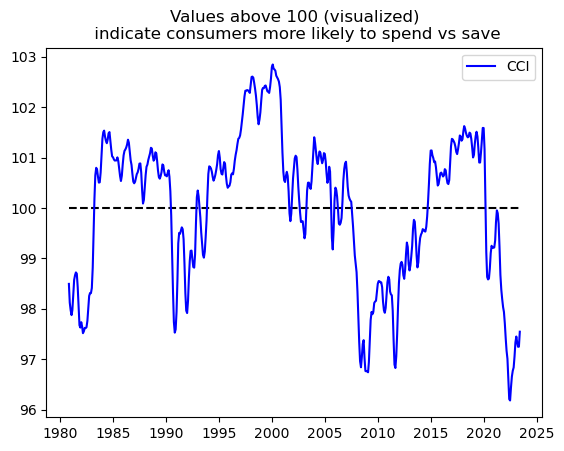

In [30]:
# Visualizing trends for `CCI Value`
plt.plot(hundred_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_plot[0]], label='CCI', color='blue')
plt.title('Values above 100 (visualized)\n indicate consumers more likely to spend vs save')
plt.legend()
plt.show()

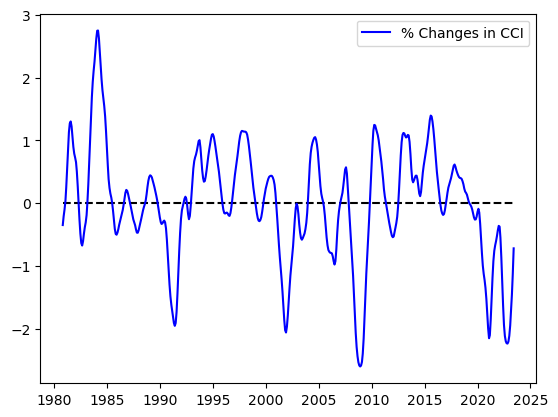

In [31]:
# Visualizing trends for `CCI Rolling Percent Change`
plt.plot(zero_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_flag[0]], label='% Changes in CCI', color='blue')
plt.legend()
plt.show()

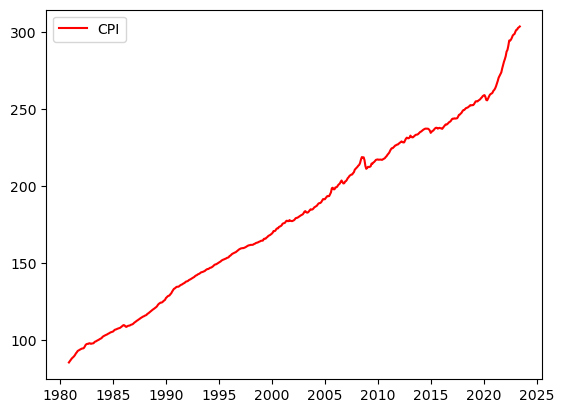

In [32]:
# Visualizing trends for `CPI Value`
plt.plot(df_economics[features_to_plot[1]], label='CPI', color='red')
plt.legend()
plt.show()

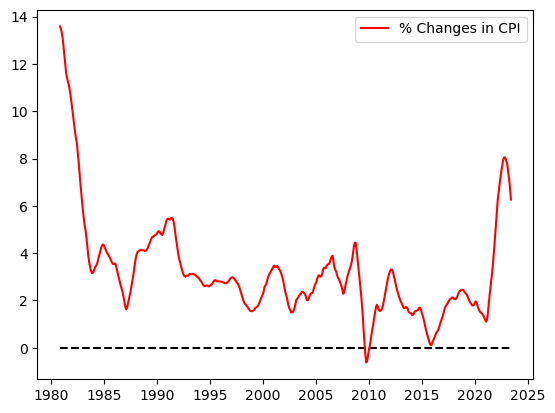

In [33]:
# Visualizing trends for `CPI Rolling Percent Change`
plt.plot(zero_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_flag[1]], label='% Changes in CPI', color='red')
plt.legend()
plt.show()

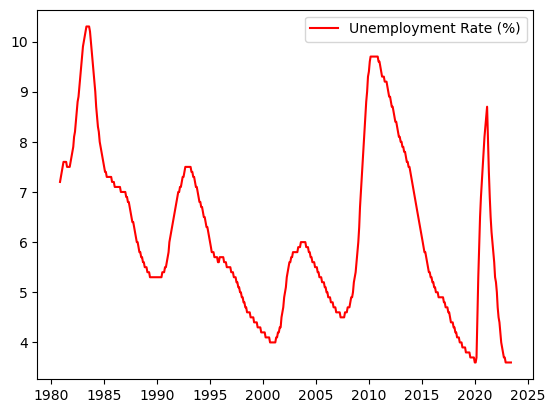

In [34]:
# Visualizing trends for `Unemployment Rate (%)`
plt.plot(df_economics[features_to_plot[2]], label='Unemployment Rate (%)', color='red')
plt.legend()
plt.show()

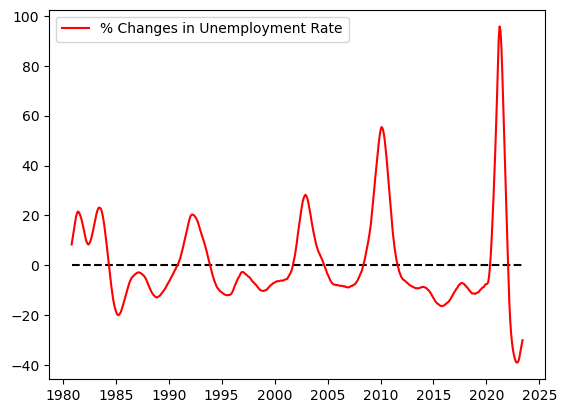

In [35]:
# Visualizing trends for `Unemployment Rate Rolling Percent Change`
plt.plot(zero_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_flag[2]], label='% Changes in Unemployment Rate', color='red')
plt.legend()
plt.show()

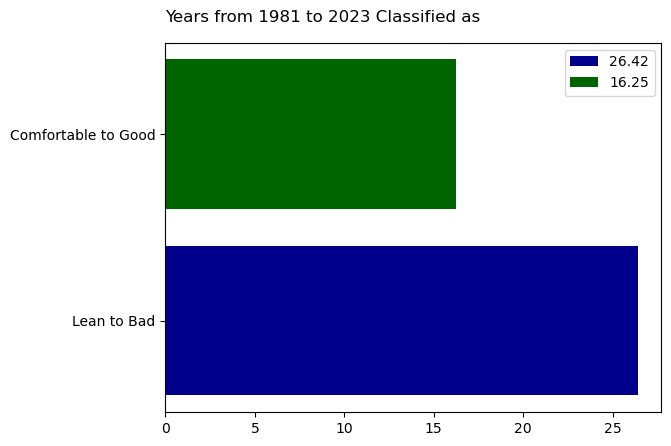

In [36]:
# Vizualizing total years classified in `Economic Climate`
plt.barh(
    y=df_economics['Economic Climate'].value_counts().index,
    width=df_economics['Economic Climate'].value_counts()/12,
    color=['darkblue', 'darkgreen'],
    label=['26.42', '16.25']
)
plt.title(
    'Years from 1981 to 2023 Classified as',
    loc='left',
    pad=15
)
plt.legend()
plt.show()

## Indexing

In [37]:
# Resetting the index to recreate `Date` for later concatenation
df_economics.reset_index(inplace=True)

# Combining Data

In [38]:
# Creating a 'Date' for a datetime index
df_movies['Date'] = pd.to_datetime({
    'year': df_movies['released_year'],
    'month': df_movies['released_month'],
    'day': df_movies['released_day']
})

# Setting `Date` as index
df_movies.set_index('Date', inplace=True)

# Ensuring index is sorted with ascending dates
df_movies.sort_index(inplace=True)

In [39]:
# Creating a `Year` and `Month` for concatenation
df_economics['Year'] = df_economics['Date'].dt.strftime('%Y').astype(int)
df_economics['Month'] = df_economics['Date'].dt.strftime('%m').astype(int)

# Renaming to `Year` and `Month` for concatenation
df_movies.rename(columns={
'released_year': 'Year',
'released_month': 'Month'
}, inplace=True)

In [40]:
# Confirming total records before concatenation
print(f'Total ecomonic records: {df_economics.shape[0]}')
print(f'Total movie records: {df_movies.shape[0]}')

Total ecomonic records: 512
Total movie records: 15363


In [41]:
# Combining datasets through concatenation
df_combined = pd.merge(df_economics, df_movies, how='left', on=['Year', 'Month'])

# Confirming total records after concatenation
print(f'Total records: {df_combined.shape[0]}')

Total records: 12609


# EDA

In [42]:
# Creating the eventual `Target` for modelling
df_combined['Target'] = df_combined['critical_success'] + ' ' +\
                        df_combined['financial_success'] + ' ' +\
                        df_combined['Economic Climate']

In [43]:
# Creating a list of features to drop
cols_to_drop = [
    'Date',
    'CCI Rolling Mean',
    'CPI Rolling Mean',
    'Unemployment Rate (%) Rolling Mean',
    'Economic Climate',
    'Year',
    'Month',
    'id',
    'cast',
    'original_language',
    'director',
    'writers',
    'producers',
    'popularity', 
    'critical_success',
    'financial_success',
    'release_date',
    'released_day',
    'production_countries',
    'status',
    'spoken_languages'
]

# Dropping unneeded features
df_combined.drop(columns=cols_to_drop, inplace=True)

In [44]:
# Dropping `NaN` records
df_combined.dropna(inplace=True)

In [45]:
# Confirming total records after concatenation
print(f'Total records: {df_combined.shape[0]}')

Total records: 10329


# Train Test Splitting

In [46]:
# Defining columns to scale and encode
col_to_scale = [
    'CCI Value', 'CCI Rolling Percent Change', 'CPI Value',
    'CPI Rolling Percent Change', 'Unemployment Rate (%)', 
    'Unemployment Rate Rolling Percent Change','vote_average', 'vote_count',
    'revenue','runtime','budget', 'roi'
]

col_to_encode = [
    'CCI Rolling Percent Change Flag', 'CPI Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag', 'title', 'original_title',
    'genres', 'production_companies'
]

# Setup X and y variables
X = df_combined.drop(columns='Target')
y = df_combined['Target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

# Scaling and Econding

In [47]:
# Creating an instance for `StandardScalar()`
scaler = StandardScaler()

# Fitting and transforming to `col_to_scale`
X_train_scaled = scaler.fit_transform(X_train[col_to_scale])
X_test_scaled = scaler.transform(X_test[col_to_scale])

# Converting results to DF for later concatenation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_to_scale)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_to_scale)

In [48]:
# Creating an instance for `OneHotEncoder()` for `X_train[col_to_encode]`
encoder_x = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fitting to `col_to_encode`
encoder_x.fit(X_train[col_to_encode])

# Creating an instance for `OneHotEncoder()` for `y_train`
encoder_y = LabelEncoder()

#Fitting
encoder_y.fit(y_train.values.ravel())

# Transforming `X_train[col_to_encode]` and `X_test[col_to_encode]`
X_train_encoded = encoder_x.transform(X_train[col_to_encode])
X_test_encoded = encoder_x.transform(X_test[col_to_encode])

# Transforming `y_train` and `y_test`
y_train_encoded = encoder_y.transform(y_train.values.ravel())
y_test_encoded = encoder_y.transform(y_test.values.ravel())

# Converting results to DF for later concatenation
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_x.get_feature_names_out())
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_x.get_feature_names_out())

In [49]:
# Concatenating the `col_to_scale` with `col_to_encode` for `X_train` and `X_test`
X_train = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_test = pd.concat([X_test_scaled, X_test_encoded], axis=1)

In [50]:
# Confirming total records after concatenation
print(f'Total X records: {X_train.shape[0] + X_test.shape[0]}')

Total X records: 10329


# Modeling

Playtime!!

# Eric's Space

# Funda's Space

# Kalvin's Space

In [51]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, precision_score

In [52]:
# Create a untuned KNN classifier
untuned_model = KNeighborsClassifier()

## Train the untuned model
untuned_model.fit(X_train, y_train_encoded)

# Check the model's accuracy on the test set
untuned_y_test_pred = untuned_model.predict(X_test)
print(accuracy_score(y_test_encoded, untuned_y_test_pred))
print(precision_score(y_test_encoded, untuned_y_test_pred, average='weighted'))

0.6527293844367015
0.6207316965007116


/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Instantiate the PCA instance and declare the number of PCA variables to retain maximum variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [54]:
# Create a untuned KNN classifier
untuned_model = KNeighborsClassifier()

## Train the untuned model
untuned_model.fit(X_train_pca, y_train_encoded)

# Check the model's accuracy on the test set
untuned_y_test_pred = untuned_model.predict(X_test_pca)
print(accuracy_score(y_test_encoded, untuned_y_test_pred))
print(precision_score(y_test_encoded, untuned_y_test_pred, average='weighted'))

0.6016260162601627
0.5793596270925286


/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


k: 1, Train/Test Score: 1.000/0.612
k: 3, Train/Test Score: 0.783/0.629
k: 5, Train/Test Score: 0.746/0.653
k: 7, Train/Test Score: 0.720/0.663
k: 9, Train/Test Score: 0.709/0.668
k: 11, Train/Test Score: 0.698/0.661
k: 13, Train/Test Score: 0.690/0.667
k: 15, Train/Test Score: 0.686/0.666
k: 17, Train/Test Score: 0.683/0.666
k: 19, Train/Test Score: 0.678/0.666
k: 21, Train/Test Score: 0.674/0.659
k: 23, Train/Test Score: 0.669/0.663
k: 25, Train/Test Score: 0.667/0.658
k: 27, Train/Test Score: 0.664/0.657
k: 29, Train/Test Score: 0.660/0.655
k: 31, Train/Test Score: 0.658/0.648
k: 33, Train/Test Score: 0.656/0.648
k: 35, Train/Test Score: 0.655/0.651
k: 37, Train/Test Score: 0.653/0.651
k: 39, Train/Test Score: 0.651/0.648


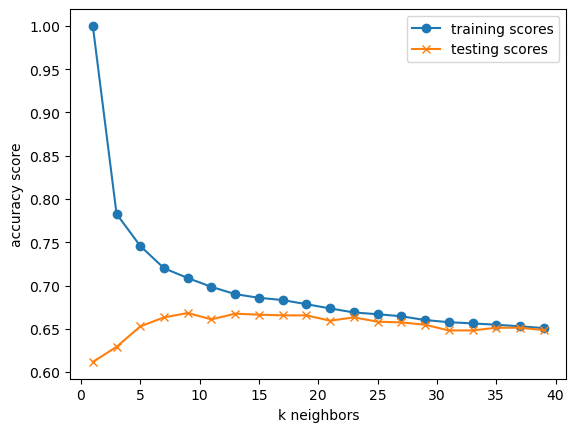

In [55]:
# Create a KNN classfier to loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 40, 2):
    loop_model = KNeighborsClassifier(n_neighbors=k)
    loop_model.fit(X_train, y_train_encoded)
    train_score = loop_model.score(X_train, y_train_encoded)
    test_score = loop_model.score(X_test, y_test_encoded)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
# Plot the results
plt.plot(range(1, 40, 2), train_scores, marker='o', label="training scores")
plt.plot(range(1, 40, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [56]:
# Choose the best k, and refit the KNN classifier by using that k value.
# Note that k=23 provides the best accuracy where the classifier is not overfitting.
loop_model = KNeighborsClassifier(n_neighbors=23)
loop_model.fit(X_train, y_train_encoded)

# Check the model's accuracy on the test set
loop_y_test_pred = loop_model.predict(X_test)
print(accuracy_score(y_test_encoded, loop_y_test_pred))
print(precision_score(y_test_encoded, loop_y_test_pred, average='weighted'))

0.6631823461091754
0.6606584074065712


/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
''' The grid search below used to hyperparameter tune the KNN Classifier provided a k value = 1, with an accurancy score of .578. 
The code has been commented out code because it took 24min to run.'''
# # Create a grid search KNN classifier
# grid_model = KNeighborsClassifier()

# # Define the parameter grid tuned KNN classifier
# param_grid = {'n_neighbors': list(range(1, 25, 2)),
#             'weights': ['uniform', 'distance'],
#             'leaf_size': [10, 50, 100, 500]
# }

# # Create a GridSearchCV model
# grid = GridSearchCV(grid_model, param_grid, verbose=3)

# # Fit the model by using the grid search estimator.
# # This will take the KNN model and try each combination of parameters.
# grid.fit(X_train, y_train_encoded)

# # Best parameter and score
# print(f"Best k: {grid.best_params_['n_neighbors']}")
# print(f"Best cross-validated accuracy: {grid.best_score_}")

' The grid search below used to hyperparameter tune the KNN Classifier provided a k value = 1, with an accurancy score of .578. \nThe code has been commented out code because it took 24min to run.'

# Odele's Space

#### Peta-Gaye's LR modelling

In [ ]:
# Declare a logistic regression model.
logistic_regression_model = LogisticRegression(max_iter=500, solver='lbfgs')

In [ ]:
# Fit and save the logistic regression model using the training data
df_combined_lr_model = logistic_regression_model.fit(X_train, y_train_encoded)

In [ ]:
# Generate predictions from the logistic regression model using the test data
lr_predictions = logistic_regression_model.predict(X_test)

# Review the predictions
lr_predictions

In [ ]:
# Display the accuracy score for the test dataset.
accuracy_score(y_test_encoded, lr_predictions)

In [ ]:
# Display the precision score for the test dataset.
precision_score(y_test_encoded, lr_predictions, average='weighted', zero_division=1)

#### End Peta-Gaye's LR modelling

# Peta's Space

# Vadim's Space

# Findings

# Additional